## Training the network

In this notebook we take the generated images in the ``eneratedData`` folder and use them to train a neural network.

### What does it all do?
We will walk througho the main steps so you can understand in basics steps in this notebook. 

---

First we need to import a couple of different libraries. You can see many of them contain the name ```troch```, this is the main machine learning library we will use. 


In [1]:
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import time
from sklearn.metrics import confusion_matrix

import soundfile as sf
import scipy.signal as sps
from nnAudio import Spectrogram


#### NOOOOO
import librosa

## Define classes to train

The less classes you have  the fewer data you need. So slecting just the right ammount of classes can be one way to reduce the ammount of processing and increase, potentially, the reliabilty.

In the following section you can select which of the found classes should be included.

In [2]:
Type="TRAINING"
exec(open("../helperFunctions.py","rb").read())

Select classes to use for training:


Checkbox(value=False, description='air_conditioner', indent=False)

Checkbox(value=False, description='car_horn', indent=False)

Checkbox(value=False, description='children_playing', indent=False)

Checkbox(value=False, description='dog_bark', indent=False)

Checkbox(value=False, description='drilling', indent=False)

Checkbox(value=False, description='engine_idling', indent=False)

Checkbox(value=False, description='environment', indent=False)

Checkbox(value=False, description='gun_shot', indent=False)

Checkbox(value=False, description='jackhammer', indent=False)

Checkbox(value=False, description='siren', indent=False)

Checkbox(value=False, description='street_music', indent=False)

UsedClasses=[]
for k in widgetDict:
    if widgetDict[k].value==True:
        UsedClasses.append(k)
if(len(UsedClasses)<2):
    print("Something is wrong here. we need at least 2 classes!")


UsedClasses=['street_music' ,'siren' ,'jackhammer' ,'engine_idling' ,'drilling' ,'dog_bark' ,'children_playing' ,'air_conditioner']

In [2]:
UsedClasses=['street_music' ,'siren' ,'children_playing' ,'dog_bark']

## Loading data set
If test set is not defined previously, this function pulls a test set from the training set using a 80/20%split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [4]:
ROOT='../AudioData/'

class AudioData(torch.utils.data.Dataset):
            """Face Landmarks dataset."""
            def __init__(self, classNumber, ClassName,root_dir,device):
                """
                Args:
                    root_dir (string): Directory with all the images.
                    transform (callable, optional): Optional transform to be applied
                        on a sample.
                """
                self.root_dir = root_dir
                self.ClassName=ClassName
                self.classNumber=classNumber
                #self.fileList=[]
                self.audioList=[]
                for f in os.listdir(root_dir):
                    if(f.endswith('.DS_Store')):
                        continue
                    if librosa.get_duration(filename=os.path.join(root_dir,f))>=1.06:
                        y, sr = librosa.load(os.path.join(root_dir,f),duration=1.05, sr=22050,mono=True)
                        #print(len(y))
                        self.audioList.append(np.array(y))
                        #self.fileList.append(f)
                self.device = device
                print("Done with class", self.ClassName,len(self.audioList),len(self.audioList[0]));
            
            def __len__(self):
                return len(self.audioList) # self.fileList
            
            def __getitem__(self, idx):
                if torch.is_tensor(idx):
                    idx = idx.tolist()
                #audio_path = os.path.join(self.root_dir,self.fileList[idx])
               
                #sr, song = wavfile.read(audio_path) # Loading your audio
               # data_, samplerate = sf.read(audio_path,always_2d=True)
                #data=data_.T[0]
                 # Your new sampling rate
                #new_rate = 22050

                # Resample data
               # number_of_samples = round(len(data) * float(new_rate) / samplerate)
                #data = sps.resample(data, number_of_samples)
                #y, sr = librosa.load(audio_path,duration=0.41, sr=22050,mono=True)
                
                x = self.audioList[idx][0:22050]  # y[0:8820]
                #print(x.shape,audio_path)
                x = torch.tensor(x, device=self.device).float() 
                return x,self.classNumber

In [35]:
classes.index("air_conditioner")

ValueError: tuple.index(x): x not in tuple

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
classes =  tuple(UsedClasses)


AllData=[]

for cl in classes:   
    trainPath=os.path.join(ROOT,cl)
    if os.path.isdir (trainPath):
        AllData.append( AudioData(classes.index(cl), cl,trainPath,device))
    else:
        print('Coud not find path',trainPath);
        

AllDataSets = torch.utils.data.ConcatDataset(AllData);
trainSize = int(len(AllDataSets)*0.8);
testSize = len(AllDataSets) - trainSize;


TrainDataSet, TestDataSet = torch.utils.data.random_split(AllDataSets, [trainSize, testSize],generator=torch.Generator().manual_seed(42))
trainloader = torch.utils.data.DataLoader(TrainDataSet, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(TestDataSet, batch_size=16, shuffle=False)

Done with class street_music 1000 23153
Done with class siren 915 23153
Done with class children_playing 999 23153
Done with class dog_bark 853 23153


## Load pretrained model 


In [7]:
import nnAudio

In [ ]:
#self.mel = nnAudio.Spectrogram.MelSpectrogram(n_fft=2048, 
                                                      n_mels=128,
                                                      hop_length=64,
                                                      power=2.0,
                                                      fmin=10.0,
                                                      fmax=8000,
                                                      sr=22050,
                                                      trainable_mel=False,
                                                      htk=True ,
                                                      trainable_STFT=False).cuda(device)

In [17]:
device

device(type='cpu')

In [34]:
class Model(torch.nn.Module):
    def __init__(self,classCount):
        super(Model,self).__init__()
        
        self.mel =  Spectrogram.STFT(n_fft=512, freq_bins=None,
                                           hop_length=128, window='hann',
                                           center=True,
                                           freq_scale = 'log',
                                           pad_mode='reflect', fmin=50,
                                           fmax=8000, sr=22050, trainable=True,
                                           output_format='Magnitude').to(device) # Using device='cuda:0'
        #torch.nn.init.xavier_uniform_(self.mel.mel_basis)
        self.CNN_layer1 = torch.nn.Conv2d(1,32, kernel_size=(12,12)).to(device)
        self.CNN_layer2 = torch.nn.Conv2d(32,64, kernel_size=(16,16)).to(device)
        self.mpool = nn.MaxPool2d(4,stride=3).to(device)
        self.fc1 = torch.nn.Linear(64* 76* 48,128).to(device)
        self.fc2 = torch.nn.Linear(128,classCount).to(device)
    def visualize(self, sound):
        return self.mel(sound)
    def forward(self, x):
        x = self.mel(x)
        #print(x.shape)
        x = self.CNN_layer1(x.unsqueeze(1))
        x = self.CNN_layer2(x)
        x = self.mpool(x)
        print(x.shape)
        x = x.view(x.data.size()[0],64* 76* 48)
        x = self.fc1(torch.relu(x))
        x = self.fc2(torch.relu(x))
        return torch.softmax(x,dim=1)

sampling rate = 22050. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0137 seconds
siren


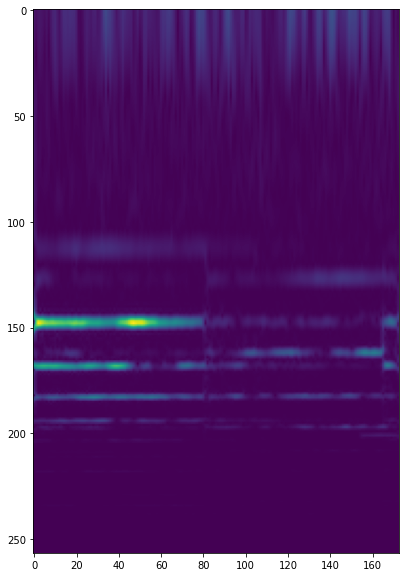

In [35]:
blup = next(iter(trainloader))
model=Model(len(classes))
spec= model.visualize(blup[0])
fig = plt.figure(figsize=(10, 10)) 
plt.imshow(spec[0].cpu().detach().numpy())
print(classes[blup[1][0]])

In [36]:
model=Model(len(classes))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

sampling rate = 22050. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0135 seconds


In [ ]:
#### Training the network on the training dataset
for i in range(5):  # loop over the dataset multiple (5) times 
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, (inputs, labels) in enumerate(trainloader, 0):
        #print("Loaded")
        #print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print("move to cuda")
        optimizer.zero_grad()
        if((i+i)%50==0):
            if(i>0):
                print('Processed images:',i*trainloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))
        # forward + backward + optimize
        outputs = model(inputs)
        #print("move through model")
        #print(outputs)
        loss = criterion(outputs, labels)
        #print("loss done")
        loss.backward()
        #print("backprop")
        optimizer.step()
        #print("optimize done")
        epochLoss+=loss.item()
        
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader, 0):
            # get the inputs
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                if(i>0):
                    print('Tested images:',i*testloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))


    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done
print('Finished Training')


Starting epoch: 1
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
Processed images: 400 . Running Timer @ 737.32sec.
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
torch.Size([16, 64, 76, 48])
tor

### Post training analytics

After the training has finished, save information about the training

In [ ]:
# saving the learnd model in file that can be loaded in for inference
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':224,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

Display how the traing and test loss progressed over successive epochs

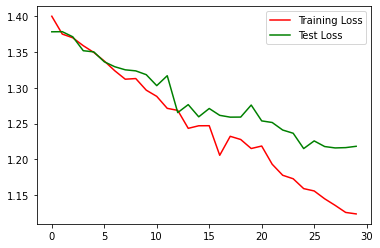

In [25]:
#Displaying how the loss progresses over time.
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.legend()
plt.show()

Show spectagrams, Predicted and Actual labels.

In [ ]:
# Print predicted and acual labels for Spectragrams
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
for i in range(trainloader.batch_size):
    imshow(images[i].cpu())
    print('GroundTruth: ',classes[labels[i]])
    print('Predicted: ',  classes[predicted[i]])


Print accuracy of test predictions for each label

In [26]:
# Network analytics
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.cuda(device)
        labels = labels.cuda(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if (c.dim()==0):
            continue
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            #print (c.shape)
            if(testloader.batch_size>1):
                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
averagePercentage = []
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    averagePercentage.append( 100 * class_correct[i] / class_total[i])
print("Average percentage:\t%2d%%"%(np.mean(averagePercentage)))

torch.Size([256, 64, 33, 5])
torch.Size([256, 64, 33, 5])
torch.Size([242, 64, 33, 5])
[[154  15  16  17]
 [ 33  87  21  32]
 [ 71  23  45  73]
 [ 21  16  31  99]]
Accuracy of street_music : 76 %
Accuracy of siren : 50 %
Accuracy of children_playing : 21 %
Accuracy of dog_bark : 59 %
Average percentage:	51%


In [ ]:
class Model(torch.nn.Module):
    def __init__(self,classCount):
        super(Model,self).__init__()
        
        self.mel = nnAudio.Spectrogram.MelSpectrogram(n_fft=2048, n_mels=64, trainable_mel=True, trainable_STFT=True).cuda(device) # Using device='cuda:0'

        self.CNN_layer1 = torch.nn.Conv2d(1,1, kernel_size=(16,16)).cuda(device)
        self.CNN_layer2 = torch.nn.Conv2d(1,1, kernel_size=(4,4)).cuda(device)
        
        self.regressor = torch.nn.Linear(46*26,classCount).cuda(device)

    def forward(self, x):
        #print(x.shape)
        x = self.mel(x)
        x = self.CNN_layer1(x.unsqueeze(1))
        x = self.CNN_layer2(x)
        #print(x.shape)
        x = x.view(x.data.size()[0], 46*26)
        x=torch.relu(x)
        #print(x.shape)
        x = self.regressor(torch.relu(x))
        return torch.sigmoid(x)

In [ ]:
'''
[[118  11  39  26]
 [ 12  81  55  20]
 [ 39  15 128  28]
 [ 25   5  22 159]]
Accuracy of street_music : 60 %
Accuracy of siren : 48 %
Accuracy of children_playing : 60 %
Accuracy of air_conditioner : 75 %
Average percentage:	61%
'''
class Model(torch.nn.Module):
    def __init__(self,classCount):
        super(Model,self).__init__()
        
        self.mel = nnAudio.Spectrogram.MelSpectrogram(n_fft=1024, n_mels=128, trainable_mel=True, trainable_STFT=True).cuda(device) # Using device='cuda:0'
        torch.nn.init.xavier_uniform_(self.mel.mel_basis)
        self.CNN_layer1 = torch.nn.Conv2d(1,8, kernel_size=(16,16)).cuda(device)
        self.CNN_layer2 = torch.nn.Conv2d(8,16, kernel_size=(16,16)).cuda(device)
        
        self.fc1 = torch.nn.Linear(16* 98* 14,128).cuda(device)
        self.fc2 = torch.nn.Linear(128,classCount).cuda(device)

    def forward(self, x):
        x = self.mel(x)
        #print(x.shape)
        x = self.CNN_layer1(x.unsqueeze(1))
        x = self.CNN_layer2(x)

       # print(x.shape)
        x = x.view(x.data.size()[0],16* 98* 14)
        x = self.fc1(torch.relu(x))
        x = self.fc2(torch.relu(x))
        return torch.softmax(x,dim=1)